Taken from https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html and modified using https://www.nature.com/articles/s41467-017-01904-7

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def oracle(val, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # Next, format 'val' as a binary string of length 'n', padded with zeros:
    b_str = format(val, '0'+str(n)+'b')
    # Next, we place the first X-gates. Each digit in our binary string 
    # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
    # we apply an X-gate to that qubit:
    for qubit in range(len(b_str)):
        if b_str[qubit] == '0':
            oracle_qc.x(qubit)
    # Do multi-controlled-X gate
    oracle_qc.mct(list(range(n)), n)
    
    
    # Next, place the final X-gates
    for qubit in range(len(b_str)):
        if b_str[qubit] == '0':
            oracle_qc.x(qubit)

    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "U$_\omega$" # To show when we display the circuit
    return oracle_gate, oracle_qc

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s, qc

In [4]:
def grover_algorithm(oracle, diffuser_gate, n):
    grover_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
#    grover_circuit.x(n-1)
#    grover_circuit.h(n-1)
    # And set up the input register:
    for qubit in range(n+1):
        grover_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    for iteration in range(int(n)):
        grover_circuit.append(oracle, range(n+1))
        grover_circuit.h(n)
        grover_circuit.append(diffuser_gate,range(n))
    # Finally, perform the H-gates again and measure:
    # for qubit in range(n+1):
        # grover_circuit.h(qubit)
    
    for i in range(n):
        grover_circuit.measure(i, i)
    
    return grover_circuit

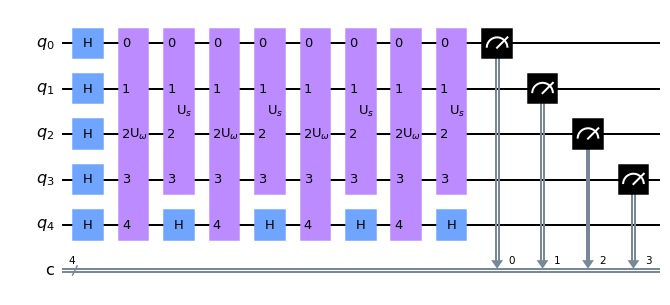

In [5]:
n = 4
oracle_gate,b = oracle(5, n)
diffuser_gate,b = diffuser(n)
grover_circuit = grover_algorithm(oracle_gate,diffuser_gate, n)
grover_circuit.draw()

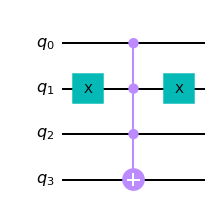

In [6]:
a,b=oracle(5,3)
b.draw()

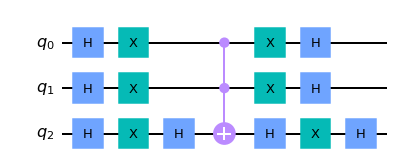

In [7]:
a,b=diffuser(3)
b.draw()

In [8]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024

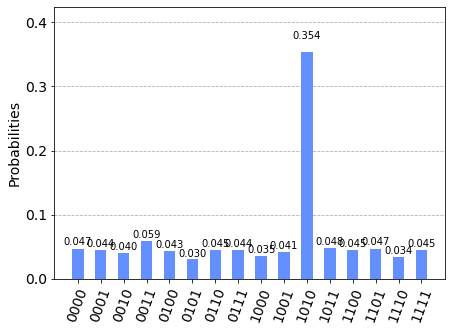

In [9]:
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
qobj = assemble(transpiled_grover_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)